In [1]:
from tensorflow.keras.layers  import Input, Conv2D, BatchNormalization, Dropout, Dense, MaxPooling2D, Flatten
from tensorflow.keras.initializers import glorot_normal 
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ShuffleSplit
import numpy as np
import pickle
import argparse
from pathlib import Path

In [2]:
import numpy as np
import tensorflow.keras as keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, SAMPLE_DIR, TARGET_DIR, list_IDs, batch_size=32, dim=(27,27), n_channels=1, n_classes=25, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.SAMPLE_DIR = SAMPLE_DIR
        self.TARGET_DIR = TARGET_DIR
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(f'{self.SAMPLE_DIR}{ID}')

            # Store class
            y[i] = np.load(f'{self.TARGET_DIR}{ID}')

        return X, y

In [3]:
IN_DIR = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest_processed/'
TEST_DIR = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/'
SAMPLE_DIR = f'{IN_DIR}samples/'
MASK_DIR = f'{IN_DIR}masks/'

In [4]:
sample_names = [path.name for path in Path(SAMPLE_DIR).glob('*.*')]
n_samples = len(sample_names)
rs = ShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
train_index, test_index = next(rs.split(np.arange(n_samples)))

rs = ShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
train_index, valid_index = next(rs.split(train_index))

print(len(train_index), len(test_index))
train_names = [sample_names[idx] for idx in train_index]
valid_names = [sample_names[idx] for idx in valid_index]
test_names =  [sample_names[idx] for idx in test_index]
print(f'train sampes: {len(train_names)}, valid sampes: {len(valid_names)}, test sampes: {len(test_names)}')

737645 327843
train sampes: 737645, valid sampes: 245882, test sampes: 327843


In [5]:
train_gen = DataGenerator(SAMPLE_DIR, MASK_DIR, train_names, batch_size = 256, dim=(27,27), n_channels=3)
valid_gen = DataGenerator(SAMPLE_DIR, MASK_DIR, valid_names, batch_size = 256, dim=(27,27), n_channels=3)

In [15]:
def create_model():
    input = Input(shape=(27,27,3))
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu',
                kernel_initializer='glorot_normal')(input)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu',
               kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu',
               kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu',
               kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu',  kernel_initializer='glorot_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu',  kernel_initializer='glorot_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(25, activation='sigmoid',  kernel_initializer='glorot_normal')(x)

    model = Model(inputs = input, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())

    return model

In [16]:
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4640      
__________

In [22]:
weight_path = f'{IN_DIR}/best_weight.hdf5'
check_point = ModelCheckpoint(weight_path, monitor='val_loss',verbose=1, save_best_only=True)
n_epochs = 50

In [18]:
hist = model.fit_generator(generator=train_gen, validation_data=valid_gen, 
                           use_multiprocessing=True, workers=6, callbacks=[check_point], epochs = n_epochs)

Epoch 1/50
2880/2881 [============================>.] - ETA: 0s - loss: 0.2503 - acc: 0.8846Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.29083, saving model to /home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest_processed//best_weight.hdf5
2881/2881 [==============================] - 123s 43ms/step - loss: 0.2503 - acc: 0.8846 - val_loss: 0.2908 - val_acc: 0.8811
Epoch 2/50
2878/2881 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9320
Epoch 00002: val_loss improved from 0.29083 to 0.14793, saving model to /home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest_processed//best_weight.hdf5
2881/2881 [==============================] - 121s 42ms/step - loss: 0.1685 - acc: 0.9320 - val_loss: 0.1479 - val_acc: 0.9394
Epoch 3/50
2879/2881 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9458
Epoch 00003: val_loss did not improve from 0.14793
2881/2881 [==============================] - 123s 43ms/step - loss: 0.1

2880/2881 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9648
Epoch 00028: val_loss did not improve from 0.07316
2881/2881 [==============================] - 123s 43ms/step - loss: 0.0857 - acc: 0.9648 - val_loss: 0.7733 - val_acc: 0.9041
Epoch 29/50
2879/2881 [============================>.] - ETA: 0s - loss: 0.0855 - acc: 0.9648
Epoch 00029: val_loss did not improve from 0.07316
2881/2881 [==============================] - 121s 42ms/step - loss: 0.0855 - acc: 0.9648 - val_loss: 0.0897 - val_acc: 0.9640
Epoch 30/50
2878/2881 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9651
Epoch 00030: val_loss did not improve from 0.07316
2881/2881 [==============================] - 121s 42ms/step - loss: 0.0849 - acc: 0.9651 - val_loss: 0.6416 - val_acc: 0.9172
Epoch 31/50
2880/2881 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9651
Epoch 00031: val_loss did not improve from 0.07316
2881/2881 [==============================] - 121s 42ms

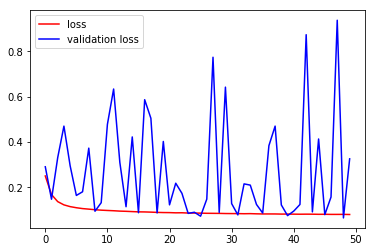

In [33]:
import matplotlib.pyplot as plt
hist.history['loss']
plt.plot(np.arange(n_epochs), hist.history['loss'], 'r', label = 'loss')
plt.plot(np.arange(n_epochs), hist.history['val_loss'],'b', label = 'validation loss')
plt.legend()

# measure accuracy

In [28]:
weight_path = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest_processed/best_weight.hdf5'

In [29]:
model = create_model()
model.load_weights(weight_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 16)        448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 27, 27, 16)        64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 16)        2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 27, 27, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        4640      
__________

In [30]:
test_gen = DataGenerator(SAMPLE_DIR, MASK_DIR, list_IDs=test_names,  batch_size = 256, dim=(27,27), n_channels=3)
acc = model.evaluate_generator(test_gen, steps=len(test_gen), verbose=1)

1280/1280 [==============================] - 364s 285ms/step


In [32]:
test_loss, test_acc = acc
print(f'loss = {test_loss}, accuracy = {test_acc}')

loss = 0.06365633502427955, accuracy = 0.9727100955322385


# inference on a single test image

In [34]:
def extract_patch(img, h):
    patches = []
    patch_locs = []
    for i in range(h, img.shape[0]-h-1):
        for j in range(h, img.shape[1]-h-1):
            patch = img[i-h:i+h+1, j-h:j+h+1, :]
            if patch.shape != (2*h+1, 2*h+1, 3):
                print(patch.shape)
            patch = (patch.astype(np.float32))/255.0
            patches.append(patch)
            patch_locs.append((i,j))
    return patches, patch_locs

def upsample_patch_predict(patch_pred, patch_locs, img_shape, h):
    img = np.zeros(img_shape[:2], dtype=np.float32)
    pred_size = 5
    patch_pred = patch_pred.reshape(patch_pred.shape[0], pred_size, pred_size)
    for idx, loc in enumerate(patch_locs):
        i = loc[0]
        j = loc[1]
        pred = patch_pred[idx, :, :]
        #print(pred)
        s = np.sum(pred[:])
        img[i,j] = s
    img = ( img - img.min()) / (img.max() - img.min())
    img = (img * 255.0).astype(np.uint8)
    return img

def predict_upsample(model, sample):
    pred = model.predict(np.expand_dims(sample, axis=0))
    pred = pred.reshape(5,5)
    pred = cv.resize(pred, (27,27))
    return pred

/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/309.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/313.jpg


/home/khanhhh/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/319.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/324.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/323.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/320.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/317.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/322.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/325.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/306.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/304.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/326.jpg
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/310.jpg
/home/khan

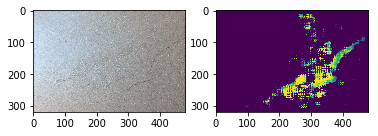

In [35]:
import util
import cv2 as cv
import matplotlib.pyplot as plt
h = 13

TEST_DIR = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_images/'
OUT_DIR = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest/test_output/'

test_files = [path for path in Path(TEST_DIR).glob('*.*')]
#fpath = test_files[np.random.randint(len(test_files))]
for fpath in test_files:
    #fpath = f'{TEST_DIR}001.jpg'
    print(fpath)
    img = cv.imread(str(fpath))
    
    patches, patch_locs = extract_patch(img, 13)

    preds = model.predict(np.array(patches))

    img_ret = upsample_patch_predict(np.array(preds), patch_locs, img.shape, h)
    img_ret = img_ret * 255.0
    
    #cv.imwrite(f'{OUT_DIR}{fpath.stem}.png', img_ret)
    plt.subplot(121); plt.imshow(img)
    plt.subplot(122); plt.imshow(img_ret)
    plt.savefig(f'{OUT_DIR}{fpath.stem}.png', dpi=500)
    #break


In [ ]:
DEBUG_DIR = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/forest_processed/debug_1/'
for i, patch in enumerate(patches):
    if i > 1000: 
        break
    cv.imwrite(f'{DEBUG_DIR}{i}.png', patch)

In [ ]:
patch = patches[np.random.randint(len(patches))]
pred_img = predict_upsample(model, patch)
print(np.sum(pred_img[:]))
plt.subplot(121); plt.imshow(patch)
plt.subplot(122); plt.imshow(pred_img)

# test on positive samples

In [ ]:
POS_DIR = f'{IN_DIR}/pos/'
POS_MASK_DIR = f'{IN_DIR}/pos_mask/'

nane = '001.npy'
pos_path = f'{IN_DIR}/pos/{name}'
pos_mask_path = f'{IN_DIR}/pos_mask/{name}'
neg_path = f'{IN_DIR}/neg/{name}'
neg_mask_path = f'{IN_DIR}/neg_mask/{name}'

idx = np.random.randint(100)
    
pos_mask = np.load(pos_mask_path)[idx]
pos_mask = pos_mask.reshape(5,5)
pos_mask = cv.resize(pos_mask, (27,27))

pos_sample = np.load(pos_path)[idx]
pred = predict_upsample(model, pos_sample)

neg_mask = np.load(n_mask_path)[idx]
neg_mask = pos_mask.reshape(5,5)
neg_mask = cv.resize(pos_mask, (27,27))

pos_sample = np.load(pos_path)[idx]
pred = predict_upsample(model, pos_sample)

plt.subplot(131), plt.imshow(pos_sample)
plt.subplot(132), plt.imshow(pos_mask)
plt.subplot(133), plt.imshow(pred)